In [1]:
import time
import warnings
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from sklearn import preprocessing, tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from scipy.stats import norm
import datetime as dt

%matplotlib inline

warnings.filterwarnings("ignore")
# https://www.kaggle.com/erick5/predicting-house-prices-with-machine-learning

In [2]:
# Columns
try:
    df = pd.read_csv("data/data_deals.csv")
except Exception:
    print("Seems we have a problem")
df.drop(columns=['_id'])
print(df.columns)
print(df.shape)

Index(['_id', 'sale_day', 'address', 'property_type', 'rooms_number', 'floor',
       'build_year', 'building_mr', 'sold_part', 'full_price', 'city'],
      dtype='object')
(517569, 11)


In [3]:
# sale_day "05-06-2016"
# build_year "2017"
df['sale_day'] = pd.to_datetime(df['sale_day'], format="%d-%m-%Y")
df['build_year'] = pd.to_datetime(df['build_year'], format="%Y")
print(df.head(1))


                        _id   sale_day        address    property_type  \
0  5cab7d497e16a98c7a79bd4a 2018-12-25  יונה הנביא 36  דירה בבית קומות   

   rooms_number floor build_year  building_mr sold_part   full_price  \
0           5.0  קרקע 2017-01-01          126       NaN  5,470,085 ₪   

          city  
0  תל אביב יפו  


In [4]:
# remove properties that their date is before 2015
from_year = 2015
# df = df.loc[(df['sale_day'].dt.year >= from_year)]
df.shape

(517569, 11)

In [5]:
# List unique values in the df['name'] column
cols = ['full_price', 'sold_part', 'floor']
for col in cols:
    try:
        df.replace({col: {'₪': '',
                          '\$': '',
                          'קרקע': 0,
                          'לא צוין מחיר': None,
                          'לא צוין': None,
                          ',': '',
                          '%': '',
                          ' ': ''}}, regex=True, inplace=True)
    except TypeError:
        # in case of double replacement
        pass
df.shape

(517569, 11)

In [6]:
# Getting Description
df = df[pd.notnull(df['floor'])]
df['floor'] = df['floor'].astype(int)
df['full_price'] = df['full_price'].astype(int)
df['full_price'].describe()

count    5.152200e+05
mean     1.067818e+06
std      9.761650e+05
min      2.000000e+00
25%      5.240000e+05
50%      8.500000e+05
75%      1.370000e+06
max      1.322710e+08
Name: full_price, dtype: float64

In [7]:
# df['street'] = df['address'].astype(float)
split_data = df['address'].str.rsplit(n=1,expand=True)
print(split_data.head(5))
df['street_name'] = split_data[0]
df['street_number'] = split_data[1]
df['street_number'].head(5)

            0   1
0  יונה הנביא  36
1  יונה הנביא  25
2  יונה הנביא  26
3  יונה הנביא  24
4  יונה הנביא  26


0    36
1    25
2    26
3    24
4    26
Name: street_number, dtype: object

In [8]:
# format sold_part to full_price
df['sold_part'] = df['sold_part'].astype(float)
df['sold_part'].fillna(100, inplace = True)
df['final_price'] = (100 / df['sold_part']) * df['full_price']
df['final_price'] = df['final_price'].astype(int)
df.drop(columns=['sold_part', 'full_price'])
print(df.head(5))



                        _id   sale_day        address    property_type  \
0  5cab7d497e16a98c7a79bd4a 2018-12-25  יונה הנביא 36  דירה בבית קומות   
1  5cab7d497e16a98c7a79bd4b 2018-12-07  יונה הנביא 25  דירה בבית קומות   
2  5cab7d497e16a98c7a79bd4c 2018-05-10  יונה הנביא 26  דירה בבית קומות   
3  5cab7d497e16a98c7a79bd4d 2018-01-24  יונה הנביא 24  דירה בבית קומות   
4  5cab7d497e16a98c7a79bd4e 2017-09-13  יונה הנביא 26  דירה בבית קומות   

   rooms_number  floor build_year  building_mr  sold_part  full_price  \
0           5.0      0 2017-01-01          126      100.0     5470085   
1           3.0      1 2018-01-01           78       10.0      410000   
2           3.0      0 1950-01-01           58      100.0     2900000   
3           1.0      1 1960-01-01           23       43.7      481250   
4           2.5      1 1930-01-01           58      100.0     2500000   

          city street_name street_number  final_price  
0  תל אביב יפו  יונה הנביא            36      5470085  
1  ת

In [9]:
# remove properties that their price is too low or too high
min_price = 100000
max_price = 5000000
df = df.loc[(min_price < df['final_price']) & (df['final_price'] < max_price)]
df.shape

(510043, 14)

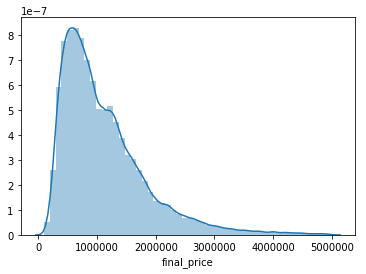

In [10]:
sns.distplot(df['final_price'])

In [11]:
df.to_csv('data/data_deals_done.csv', encoding='utf-8', index=False)

In [12]:
used_features = ['sale_day', 'street_name', 'street_number', 'property_type', 'rooms_number', 'floor',
       'build_year_class', 'building_mr', 'city']

#df['sale_day'] = df['sale_day'].map(dt.datetime.toordinal)
year_classes = {
    'A': range(2016,2030), 
    'B': range(2009,2016),
    'C': range(1,2009)
}

def year_norm(_year):
    for _class, _range in year_classes.items():
        if int(_year.year) in _range:
            return _class
    return 'C'

#df['build_year'] = df['build_year'].map(dt.datetime.toordinal)
df['build_year_class'] = df['build_year'].map(year_norm)
print(df['build_year_class'].describe())

count     510043
unique         3
top            C
freq      425941
Name: build_year_class, dtype: object


In [13]:
X = df[used_features]
y = df['final_price']

In [14]:
# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
# integer encode
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
# integer_encoded = df.apply(le.fit_transform)

# apply the values into the original data
for row in X[used_features]:
    X[row] = le.fit_transform(df[row])


In [15]:
cat = len(X.select_dtypes(include=['object']).columns)
num = len(X.select_dtypes(include=['int64','float64', 'datetime']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

df.isna().any()

Total Features:  0 categorical + 9 numerical = 9 features


_id                 False
sale_day            False
address             False
property_type       False
rooms_number        False
floor               False
build_year          False
building_mr         False
sold_part           False
full_price          False
city                False
street_name         False
street_number       False
final_price         False
build_year_class    False
dtype: bool

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [17]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
print(lm.intercept_)

-187153.71594619914


In [19]:
print(X.columns)
print(lm.coef_)

Index(['sale_day', 'street_name', 'street_number', 'property_type',
       'rooms_number', 'floor', 'build_year_class', 'building_mr', 'city'],
      dtype='object')
[ 1.14452859e+02 -8.79296314e+00  1.11655642e+01 -1.04817054e+04
  2.11797989e+04  2.15562961e+04 -1.56990969e+05  8.58291314e+03
  2.72148920e+03]


In [20]:
predictions = lm.predict(X_test)

Text(0, 0.5, 'Predicted Y')

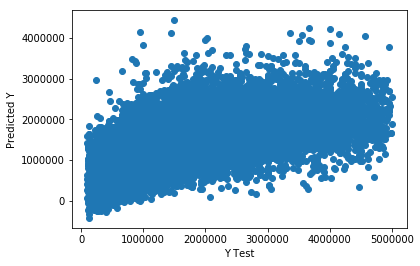

In [21]:
plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

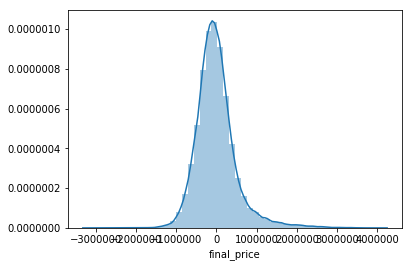

In [22]:
sns.distplot((y_test-predictions),bins=50);

In [23]:
lm.score(X,y)

0.4824511090998702

In [24]:
import statsmodels.api as sm
X_constant = sm.add_constant(X)
model = sm.OLS(y, X_constant)
lin_reg = model.fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            final_price   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                 5.283e+04
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:14:21   Log-Likelihood:            -7.4369e+06
No. Observations:              510043   AIC:                         1.487e+07
Df Residuals:                  510033   BIC:                         1.487e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.878e+05   6723.760    -27.930      0.000   -2.01e+05   -1.75e+05
sale_day           114.5232      0.589    194.274      0.000     113.368     115.679
street_name         -8.8442      0.654    -13.523      0.000     -10.126      -7.562
street_number       11.9401      1.948      6.128      0.000       8.121      15.759
property_type    -1.054e+04    711.387    -14.816      0.000   -1.19e+04   -9145.374
rooms_number      2.082e+04    664.967     31.308      0.000    1.95e+04    2.21e+04
floor             2.162e+04    229.791     94.101      0.000    2.12e+04    2.21e+04
build_year_class -1.572e+05   1605.901    -97.886      0.000    -1.6e+05   -1.54e+05
building_mr       8598.8165     40.239    213.693      0.000    8519.949    8677.684
city              2726.6664     12.780    213.358      0.000    2701.618    2751.714
==============================================================================
Omnibus:                   158404.744   Durbin-Watson:                   0.558
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           749108.497
Skew:                           1.444   Prob(JB):                         0.00
Kurtosis:                       8.188   Cond. No.                     4.95e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""